# pmaps DataBaseCreator 
### GDL 29/10/2018

<i>
This notebook applies corrections to pmaps to produce an energy spectrum and saves them to file

</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Tue Oct 30 17:22:45 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## INPUTS

In [5]:
input_type       = 'pmaps_gd'
run_number       = 6206
partlim          = [0, 6]

input_directory  = "."
output_directory = "."
typo             = "Tlpk"

#Selected pmaps_gd
if input_type == 'pmaps_gd':
    input_files =["{}/pmaps_{}_{}_{}.h5"  .format(input_directory, part, run_number, typo) for part in range(partlim[0], partlim[1]+1)]
    output_file ="{}/corrections_{}_{}.h5".format(output_directory, run_number, typo)

In [6]:
print(input_files)

['./pmaps_0_6206_Tlpk.h5', './pmaps_1_6206_Tlpk.h5', './pmaps_2_6206_Tlpk.h5', './pmaps_3_6206_Tlpk.h5', './pmaps_4_6206_Tlpk.h5', './pmaps_5_6206_Tlpk.h5', './pmaps_6_6206_Tlpk.h5']


### Imports

In [7]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   invisible_cities.io.hits_io         import load_hits
from   invisible_cities.io.dst_io          import load_dst
import invisible_cities.io.pmaps_io        as pmio

import invisible_cities.database.load_db           as db

from invisible_cities.core .core_functions import in_range

import krcal.utils.hst_extend_functions   as hst
import krcal.dev.corrections              as corrections

import csth.utils.pmaps_functions         as pmapsf
import csth.utils.hpeak_tables            as hptab
#import csth.utils.hpeak_pmaps_functions   as hppmap
import csth.utils.hpeak_pmaps_newfunctions  as hppmap
import csth.utils.hpeak_plot_functions    as hpplot

In [8]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

## Calibration imports

In [9]:
correction_filename = f"$IC_DATA/maps/kr_corrections_run{run_number}.h5"
correction_filename = os.path.expandvars(correction_filename)
calibrate = corrections.Calibration(correction_filename, 'scale')

datasipm = db.DataSiPM(run_number)
sipms_xs, sipms_ys = datasipm.X.values, datasipm.Y.values

calibration file : /home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run6206.h5
node             : scale
Energy   scale : 10069.6 (pes)
Lifetime scale : 2324.4 (us) 
Charge   scale : 598.7 (pes)


## COPY FROM JAH

In [10]:
input_filenames = [os.path.expandvars(fi) for fi in input_files]
print(input_filenames)

['./pmaps_0_6206_Tlpk.h5', './pmaps_1_6206_Tlpk.h5', './pmaps_2_6206_Tlpk.h5', './pmaps_3_6206_Tlpk.h5', './pmaps_4_6206_Tlpk.h5', './pmaps_5_6206_Tlpk.h5', './pmaps_6_6206_Tlpk.h5']


In [11]:
pmaps = pmapsf.get_pmaps(input_filenames[0], 'gd')
pmaps;

In [12]:
#runinfo = load_dst(input_filenames[0], 'Run', 'events')
#runinfo.head()
runinfo = pd.HDFStore(input_filenames[0])['/runinfo']
runinfo.head()

,evt_number,timestamp
23,5210,1531471818538
25,21814,1531472144806
331,49749,1531472690381
179,52392,1531472741667
265,52824,1531472749652


In [13]:
evtlist = hppmap.event_list(pmaps)
evtlist

EventList(event=[5210, 21814, 49749, 52392, 52824, 66349, 89112, 91010, 133477, 215009, 269246, 275839, 297003, 302436, 313839, 365224, 379269, 403518, 413916, 421472, 433934, 448436, 464697, 470975, 471975, 519330, 542668, 545747, 568926, 575688, 586212, 637052, 752037, 762787, 765025, 770683, 799733, 813481, 826834, 826851, 876545, 877899, 879842, 902919, 903055, 917444, 969456, 997821, 1008225, 1009433, 1018929, 1022749, 1022834, 1052281, 1088488, 1089952, 1098789, 1102454, 1134145, 1144756, 1166056, 1300432, 1357146, 1384354, 1444968, 1459283, 1498377, 1500346, 1504854, 1566783, 1592819, 1614546, 1651229, 1658855, 1690899, 1708646, 1744054, 1758044, 1768171, 1786141, 1786884, 1788902, 1791699, 1795037, 1817351, 1825141, 1839493, 1878882, 1925646, 1989728, 1995266, 1999704, 2003311, 2068555, 2099842, 2109356, 2129114, 2157628, 2174259, 2203274], peak=[1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 3, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 4, 2, 2, 1, 1

In [17]:
evt, ipk, loc = 5210, 0, 17
s1, s2, s2i = pmaps.s1, pmaps.s2, pmaps.s2i
rsel = (runinfo.evt_number == evt)
tsel = (s1.event == evt)  & (s1.peak == ipk)
ssel = (s2.event == evt)  & (s2.peak == ipk)
hsel = (s2i.event == evt) & (s2i.peak == ipk)

In [18]:
#time, s1e, t0  = hppmap.event_s1_info(s1[tsel], runinfo[rsel], evt)
s1e, t0 =  hppmap.event_s1_info(s1[tsel])
print(t0)

270.2529443761184


In [19]:
nslices, z0i, e0i       = hppmap.event_slices(s2[ssel], t0)
nhits, noqhits, x0ij, y0ij, z0ij, q0ij = hppmap.event_hits(s2i[hsel], z0i, sipms_xs, sipms_ys)
x0, y0, z0, q0, e0     = hptab.event_eqpoint(e0i, z0i, x0ij, y0ij, q0ij)
rmax = hptab.max_radius_hit(x0ij, y0ij)
noqslices, ei, qij, eij  = hptab.calibrate_hits(e0i, z0i, x0ij, y0ij, z0ij, q0ij, calibrate)
print(noqslices)
x , y ,  z, q , e      = hptab.event_eqpoint(ei , z0i, x0ij, y0ij, eij)

8


In [20]:
esum = hppmap.event_summary(pmaps, runinfo, evt, ipk, loc, calibrate, sipms_xs, sipms_ys)
esum
edf = hppmap.events_summary(pmaps, runinfo, loc, sipms_xs, sipms_ys, calibrate)
edf.head()

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,5210,0,17,104,1655,8,13435,1531471818538,801.035461,270.252944,...,-66.528209,79.494401,423.263062,27541.625000,583616.875000,-66.825338,79.747526,424.318138,34766.582861,651319.875416
1,21814,0,17,58,1359,4,14680,1531472144806,632.102478,458.911360,...,85.016451,-13.134833,214.083267,34229.054688,666197.437500,85.099823,-13.168215,214.265463,38542.483520,662014.040271
2,49749,0,17,9,25,3,44,1531472690381,726.294556,479.877016,...,-83.119565,32.872074,172.974396,275.492889,7469.683105,-83.119010,32.878988,172.973280,290.477525,7084.192211
3,49749,1,17,108,1589,5,15315,1531472690381,726.294556,479.877016,...,-26.369277,15.674682,280.453827,30718.068359,676024.750000,-26.538571,15.579407,280.736583,34243.763320,645719.975302
4,52392,0,17,93,1546,4,14350,1531472741667,595.690857,515.918773,...,85.341432,81.341013,184.272369,27199.216797,607946.750000,87.245057,82.637110,183.608361,33948.578788,654418.924694


In [21]:
def _partition(filename):
    words = filename.split('_')
    partition = int(words[1])
    return partition

def _clarice_pmaps_gd(file, xpos, ypos, calibrate, output_filename):
    try:
        pmaps   = pmapsf.get_pmaps(file, 'gd')
        runinfo = pd.HDFStore(file)['/runinfo']
    except OSError:
        return 0., 0.
    partition = _partition(file)
    edf = hppmap.events_summary(pmaps, runinfo, partition, xpos, ypos, calibrate)
    #edf .to_hdf(output_filename, key = 'edf'   , append = True)
    itot, iacc = len(set(pmaps.s1.event)), len(set(edf.event))
    return itot, iacc

In [22]:
_clarice_pmaps_gd(input_filenames[0], sipms_xs, sipms_ys, calibrate, 'n')

(100, 100)

In [27]:
_partition(input_filenames[3])

3

In [34]:
filename = '/path_to/data/pmaps_5_tag.h5'

In [33]:
#_partition(filename)

In [38]:
fdir = filename.split('/')
words = fdir[-1].split('_')
partition = int(words[1])

In [35]:
cor = pd.HDFStore('corrections_6206_Cs.h5')['/edf']

In [61]:
cor[cor['loc']==3]

,event,peak,loc,nslices,nhits,noqslices,noqhits,time,s1e,t0,...,x0,y0,z0,q0,e0,x,y,z,q,e
0,100088,0,3,37,372,8,2384,1531473679277,177.347046,295.628020,...,-34.525576,-112.147047,369.831940,7771.589844,153489.218750,-34.355896,-112.362105,369.614346,8668.198222,160958.805339
1,100258,0,3,32,368,6,1978,1531473682509,193.729172,283.396101,...,-141.172541,67.210238,377.491882,7186.807617,137062.531250,-141.190377,67.164614,377.492080,9113.943202,164167.208318
2,100623,0,3,28,317,2,2193,1531473689409,132.950592,539.226963,...,145.298833,-28.229674,126.078888,8199.822266,153202.031250,145.346516,-28.219128,126.063989,8961.786378,162996.052414
3,100837,0,3,23,284,6,1798,1531473693439,186.590179,275.662525,...,-31.573988,100.341790,382.438721,7289.335449,141175.687500,-31.430700,100.427358,382.444829,9201.017533,157115.327097
4,101178,0,3,42,303,3,2136,1531473700268,161.357605,440.816855,...,48.363158,80.613648,221.156158,6576.396973,149301.343750,48.229314,80.567351,221.207541,7956.856006,154120.798225
5,101615,0,3,9,42,3,103,1531473708557,156.844971,505.551027,...,-159.870475,-58.049692,147.373795,766.703308,14640.269531,-159.928336,-58.012635,147.374294,746.602394,15482.819334
6,101615,1,3,27,289,4,1734,1531473708557,156.844971,505.551027,...,-99.382039,88.627303,226.920731,6626.332031,127392.554688,-99.771825,89.174141,226.480480,7796.282576,150228.650039
7,101778,0,3,25,325,6,1921,1531473711924,194.246017,279.888611,...,80.370351,-123.356044,380.964874,7403.896484,139166.250000,80.445108,-123.425449,381.007295,9247.551432,161428.100010
8,102469,0,3,28,294,2,2157,1531473725369,149.101028,505.761984,...,-89.812553,85.138034,153.322876,7834.322266,152464.890625,-89.840365,85.109298,153.318153,8408.868676,155338.871092
9,102469,1,3,8,21,3,52,1531473725369,149.101028,505.761984,...,-109.294070,37.247576,206.250061,235.435669,8152.564941,-109.375762,37.082431,206.252277,269.495507,8145.638932


## Load hits

In [7]:
pmaps = pmapsf.get_pmaps(input_pmaps_filenames[0], 'gd')

In [8]:
evtlist = hppmap.event_list(pmaps)
evtlist;

In [15]:
edf = hppmap.event_table_fast(pmaps, sipms_xs, sipms_ys, calibrate)

NameError: name 'input_filenames' is not defined

In [ ]:
edf

### One go

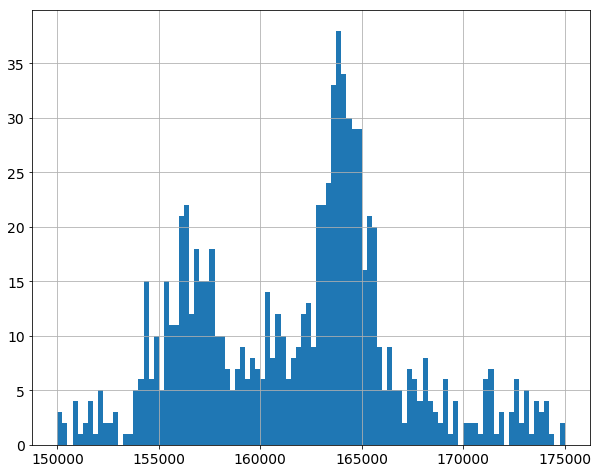

In [16]:
edf['e'].hist(bins = 100, range=(150e3, 175e3));

# Data Base

This is a loop in all the files containing the hdsts of Cs.

In [7]:
filesave = f"pmaps_corrected_{region}_{run_number}.h5"

In [9]:
i = 1
for file in input_pmaps_filenames:
    
    pmaps = pmapsf.get_pmaps(file, 'gd')

    edf = hppmap.event_table_fast(pmaps, sipms_xs, sipms_ys, calibrate)
    
    edf.to_hdf(filesave, key = '', append = True)
    
    print(f"Processed files: {i}/{n_lastchunk+1}")
    
    i += 1

total number of peaks  1093
processed  250 peaks
processed  500 peaks
processed  750 peaks
processed  1000 peaks
Processed files: 1/1
